# **Markov Language Model**

The purpose of this project is to randomly generate a codebook, by using which the normal English messages are encoded into a cipher. Then based on the cipher just generated, implement markov model with maximum likelihood estimation as well as genetic algorithm to training and find the decodebook, such that the cipher would be decoded to the original message.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import string
import random
import requests
import re
import os
import textwrap

## **Create codebook**
Now, randomly generate a codebook to encode English words. the codebook is constrained by:
<br>
1. Every letter should appear only once in the codebook.
2. Every letter should be one-to-one mapping in the codebook.
3. Only consider lowercase letters.

In [3]:
# create two lowercase list
list1 = list(string.ascii_lowercase)
list2 = list(string.ascii_lowercase)

In [4]:
print(list1)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [5]:
# Shuffle list2 and create one-to-one mapping to list1 (codebook)
random.shuffle(list2)

codebook = {key: val for key, val in zip(list1, list2)}

In [6]:
print(codebook)

{'a': 'q', 'b': 'i', 'c': 'v', 'd': 'z', 'e': 'e', 'f': 'n', 'g': 'h', 'h': 'd', 'i': 'u', 'j': 'a', 'k': 's', 'l': 'x', 'm': 'l', 'n': 'p', 'o': 'c', 'p': 'k', 'q': 'f', 'r': 'g', 's': 'b', 't': 'm', 'u': 'w', 'v': 'o', 'w': 'j', 'x': 'r', 'y': 'y', 'z': 't'}


## **Markov Model**
The probalobity of each word can be modeled by using a markov model, with uni-gram (current state) as well as bi-gram model (current state -> next state). Maxmize the log-likelihood of the product of state probability vector and Markov transition matrix.
<br>
<br>
Define functions that update the initial state probability vector once see a word start with a letter ch1, the update the Markov transition matrix according to the order of each letter in this word.
<br>
<br>
The goal is to maximize the likelihood (probability) of the word. (with assumption the next letter only depends on the previous letter)
<br>
<br>
$ max. \; \prod_i^n\ P(letter_i|letter_{i-1}) = P(letter_0)P(letter_1|letter_0)...P(letter_i|letter_{i-1})$
<br>
<br>
Then take the log to handle the small value of likelihood problem (accuracy) The log-likelihood is then become
<br>
<br>
$ max. \; \sum_i^n\ log\:P(letter_i|letter_{i-1}) = log\:P(letter_0) +\:log\:P(letter_1|letter_0)...+\:log\:P(letter_i|letter_{i-1})$


In [7]:
# initialize previous state probability vector and markov transition matrix

# current state probability vector
pi = np.zeros(26)

# markov transition matrix
M = np.ones((26,26))

# update the current state probability distribution (count of current letter ch --- uni-gram)
def update_state(pi, ch):
  # get the integer representation of a letter ch
  i = ord(ch) - ord('a')
  pi[i] += 1
  return pi

# update Markov matrix (count of consecutive letter ch1,ch2 --- bi-gram)
def update_Markov_matrix(M, ch1, ch2):
  # get the index of letter ch1 and ch2
  i, j = ord(ch1) - ord('a'), ord(ch2) - ord('a')
  M[i][j] += 1
  return M

In [8]:
# get the log-likelihood of a word / token
def word_log_likelihood(word, pi, M):

  i = ord(word[0]) - ord('a')
  log_likelihood = np.log(pi[i])

  for ch in word[1:]:

    j = ord(ch)  - ord('a')

    log_likelihood += np.log(M[i,j])
    i = j
  return log_likelihood

# get the log-likelihood of a sequence of words
def sequence_log_likelihood(words, pi, M):

  if type(words) == str:
    words = words.split()

  log_likelihood = 0
  for word in words:
    log_likelihood += word_log_likelihood(word, pi, M)
  return log_likelihood


## **Model Training**
Training the Markov mode by using a a English text file.

In [9]:
from google.colab import files

# one can get the text from 'https://lazyprogrammer.me/course_files/moby_dick.txt'

uploaded = files.upload()

Saving moby_dick.txt to moby_dick.txt


In [11]:
# for replacing non-alpha characters
regex = re.compile('[^a-zA-Z]')

with open('moby_dick.txt', encoding='UTF-8', errors='ignore') as f:
  for line in f:
    line = line.rstrip()

    # there are blank lines in the file
    if line:
      line = regex.sub(' ', line) # replace all non-alpha characters with space

      # split the tokens in the line and lowercase
      tokens = line.lower().split()

      for token in tokens:
        # update the model

        # first letter used to update state probability vector
        ch0 = token[0]
        pi = update_state(pi, ch0)

        # other letters used to update Markov matrix
        for ch1 in token[1:]:
          M = update_Markov_matrix(M, ch0, ch1)
          ch0 = ch1

# normalize the probabilities
pi /= pi.sum()
M /= M.sum(axis=1, keepdims=True)

In [12]:
print(pi.sum())
print(M.sum(axis=1))

0.9999999999999999
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]


Encode a message by using the codebook generated previously.

In [15]:
        # this is a random excerpt from Project Gutenberg's
# The Adventures of Sherlock Holmes, by Arthur Conan Doyle
# https://www.gutenberg.org/ebooks/1661

original_message = '''I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was compelled to listen to.
'''

# Away they went, and I was just wondering whether I should not do well
# to follow them when up the lane came a neat little landau, the coachman
# with his coat only half-buttoned, and his tie under his ear, while all
# the tags of his harness were sticking out of the buckles. It hadn't
# pulled up before she shot out of the hall door and into it. I only
# caught a glimpse of her at the moment, but she was a lovely woman, with
# a face that a man might die for.

# My cabby drove fast. I don't think I ever drove faster, but the others
# were there before us. The cab and the landau with their steaming horses
# were in front of the door when I arrived. I paid the man and hurried
# into the church. There was not a soul there save the two whom I had
# followed and a surpliced clergyman, who seemed to be expostulating with
# them. They were all three standing in a knot in front of the altar. I
# lounged up the side aisle like any other idler who has dropped into a
# church. Suddenly, to my surprise, the three at the altar faced round to
# me, and Godfrey Norton came running as hard as he could towards me.

In [16]:
# define an encoding function that encodes a message
def encode_func(message):

  message = message.lower()

  # replace non-alphabetic characters
  message = regex.sub(' ', message)

  # encoding message
  encode_message = []
  for ch in message:
    if ch in codebook:
      encode_ch = codebook[ch]
    else:
      encode_ch = ch # could just be a space
    encode_message.append(encode_ch)

  return ''.join(encode_message)

# define a decoding function to decodes a message
def decode_message(message, decodebook):
  decoded_message = []
  for ch in message:
    if ch in decodebook:
      decoded_ch = decodebook[ch]
    else:
      decoded_ch = ch
    decoded_message.append(decoded_ch)

  return ''.join(decoded_message)


In [17]:
encoded_message = encode_func(original_message)
encoded_message

'u mdep xcwphez zcjp mde bmgeem qpz ncwpz  qb u erkevmez  mdqm mdege jqb q lejb up q xqpe jduvd gwpb zcjp iy cpe jqxx cn mde hqgzep  u xepm mde cbmxegb q dqpz up gwiiuph zcjp mdeug dcgbeb  qpz geveuoez up ervdqphe mjckepve  q hxqbb cn dqxn qpz dqxn  mjc nuxxb cn bdqh mciqvvc  qpz qb lwvd upncglqmucp qb u vcwxz zebuge qicwm lubb qzxeg  mc bqy pcmduph cn dqxn q zctep cmdeg keckxe up mde peuhdicwgdccz up jdcl u jqb pcm up mde xeqbm upmegebmez  iwm jdcbe iuchgqkdueb u jqb vclkexxez mc xubmep mc  '

## **Genetic Algorithm**

Use genetic algorithm to find the optimal solution.

### **Offspring Evolution**

First initialize $N$ random codebook, because the constrain of encoding codebook, the letters are one-to-one mapping and no letter appears more than once. So for each of the $N$ ancestor codebooks, perform a log-likelihood estimation, pick the $K$ best results as the parents of next generation, then for each parent, generate $N/K - 1$ mutant offspring codebooks by simply select one pair of letter, and swap their position. After this add these $K (N/K - 1)$ mutant offsprings to the generation pool. Finally, the total number of codebooks will be $N$ again.

In [18]:
# Initilize a dna pool of codebooks
def dna_pool_init(N):
  dna_pool = []
  for _ in range(N):
    dna = list(string.ascii_lowercase)
    random.shuffle(dna)
    dna_pool.append(dna)

  return dna_pool

# generate offspring for each codebook
def evolve_offspring(dna_pool, n_children):

  offspring = []
  for dna in dna_pool:
    for _ in range(n_children):
      copy_dna = dna.copy()
      i, j = np.random.randint(len(copy_dna)), np.random.randint(len(copy_dna))
      
      # swap the position of pair letters of parent to generate offspring
      copy_dna[i], copy_dna[j] = copy_dna[j], copy_dna[i] 
      offspring.append(copy_dna)

  return dna_pool + offspring


In [23]:
n_iter = 1000
N = 20
n_children = 10
K = N // (n_children + 1)
max_score = float('-inf')
optimal_decodebook = None
scores = np.zeros(n_iter)
dna_pool = dna_pool_init(N)


for iter in range(n_iter):

  dna_score = {}
  if iter > 0:
    dna_pool = evolve_offspring(dna_pool, n_children)


  for dna in dna_pool:
    decodebook_test = {key:val for key,val in zip(dna, list1)}
    decoded_message = decode_message(encoded_message, decodebook_test)

    # get the log_likelihood (score) of decoded message
    score = sequence_log_likelihood(decoded_message, pi, M)

    # save the current dna and the corresponding score
    dna_score[''.join(dna)] = score
    if score > max_score:
      max_score  = score
      optimal_decodebook = decodebook_test

  # save the avg score of each iteration
  scores[iter] = np.mean(list(dna_score.values()))


  # keep the optimal K results, copy their dna (strings) and convert them back to the dna (list)
  # use those K dna (list) as the parents of next generation
  # use reverse to sort in a descending order
  dna_score_sorted = sorted(dna_score.items(), key = lambda x: x[1], reverse=True)
  dna_pool = [list(key) for key, val in dna_score_sorted[:K]]


  if iter % 200 == 0:
    print("iteration:", iter, "avg score:", scores[iter], "max score:", max_score)


iteration: 0 avg score: -2051.5095620800203 max score: -1643.9792554309429
iteration: 200 avg score: -1046.2398603374925 max score: -974.8281334039318
iteration: 400 avg score: -1006.6173462616939 max score: -929.3803194298681
iteration: 600 avg score: -1064.3742633892227 max score: -929.3803194298681
iteration: 800 avg score: -1107.3723186571378 max score: -929.3803194298681


In [24]:
# use the 
decoded_message = decode_message(encoded_message, optimal_decodebook)

print("LL of decoded message:", sequence_log_likelihood(decoded_message, pi, M))
print("LL of true message:", sequence_log_likelihood(regex.sub(' ', original_message.lower()), pi, M))


# which letters are wrong?
for true, v in codebook.items():
  pred = optimal_decodebook[v]
  if true != pred:
    print("true: %s, pred: %s" % (true, pred))

LL of decoded message: -929.3803194298681
LL of true message: -932.8073149299468
true: j, pred: z
true: k, pred: q
true: q, pred: j
true: z, pred: k


In [25]:
decoded_message

'i then lounged down the street and found  as i expected  that there was a mews in a lane which runs down by one wall of the garden  i lent the ostlers a hand in rubbing down their horses  and received in exchange twopence  a glass of half and half  two fills of shag tobacco  and as much information as i could desire about miss adler  to say nothing of half a doken other people in the neighbourhood in whom i was not in the least interested  but whose biographies i was compelled to listen to  '

In [21]:
# print the final decoded message
print("Decoded message:\n", textwrap.fill(decoded_message))

print("\nTrue message:\n", original_message)

Decoded message:
 i then lounged down the street and found  as i expected  that there
was a mews in a lane which runs down by one wall of the garden  i lent
the ostlers a hand in rubbing down their horses  and received in
exchange twopence  a glass of half and half  two fills of shag tobacco
and as much information as i could desire about miss adler  to say
nothing of half a doken other people in the neighbourhood in whom i
was not in the least interested  but whose biographies i was compelled
to listen to

True message:
 I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was 

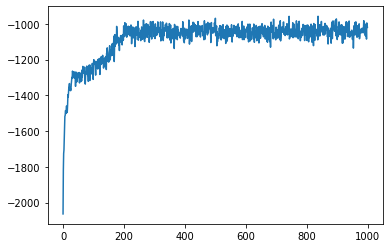

In [22]:
plt.plot(scores)
plt.show()

## **Conclusion**
The genetic algorithm provides an approach to find the (local) optimal solution where the objective function is not diffrentiable (thus can not perform a gradiant descend). The algorithm has successfully led the candidates evolved toward to the true result, in this case, the true codebook.